In [1]:
import pyagrum as gum
import pyagrum.lib.notebook as gnb
import pyagrum.causal as csl 
import pyagrum.causal.notebook as cslnb
from typing import Generator

In [2]:
def IDToBN(id: gum.InfluenceDiagram) -> gum.BayesNet:
    '''
    Description: 
    Converts an influence diagram to a bayesian diagram with the same structure.

    Arguments:
    id : gum.InfluenceDiagram

    Returns: 
    res : gum.BayesNet
    '''
    v = len(id.nodes()) # number of vertices in the graph
    res = gum.BayesNet()
    for i in range(v):  # copy nodes over
        res.add(gum.LabelizedVariable(str(i)))
    for src, dst in id.arcs():  # copy arcs over
        res.addArc(str(src), str(dst))
    return res

def getChanceNodes(id: gum.InfluenceDiagram) -> Generator[int, None, None]:
    ''' 
    Get all chance nodes in IDs.

    Yields the chance nodes in id.
    '''
    for node in id.nodes():
        if id.isChanceNode(node):
            yield node

def getDecisionNodes(id: gum.InfluenceDiagram) -> Generator[int, None, None]:
    ''' 
    Get all decision nodes in IDs.

    Yields the decision nodes in id.
    '''
    for node in id.nodes():
        if id.isDecisionNode(node):
            yield node

def getUtilityNodes(id: gum.InfluenceDiagram) -> Generator[int, None, None]:
    ''' 
    Get all utility nodes in IDs.

    Yields the utility nodes in id.
    '''
    for node in id.nodes():
        if id.isUtilityNode(node):
            yield node

def getRelU(id, decisionSet : set[int]) -> Generator[int, None, None]:
    '''
    Description:
    Get generator of relevant utility nodes to decisionSet in the ID

    Arguments:
    id : gum.InfluenceDiagram
    decisionSet : set[int]

    Returns a generator with all utility nodes that are descendants of nodes in decisionSet
    '''
    for u in set().union(*[id.descendants(i) for i in decisionSet]):
        if id.isUtilityNode(u):
            yield u

def backdoorBetweenSets(bn: gum.BayesNet, causeSet: set[int], effectSet: set[int], notBD: set[int]=set()) -> set[int]:
    ''' 
    Description:
    Get all backdoor sets between two sets of nodes

    Arguments:
    bn : gum.BayesNet
    causeSet : set[int]
    effectSet : set[int]
    notBD : set[int]

    Returns BD(causeSet, effectSet) excluding nodes in notBD
    '''
    if notBD is None:
        notBD = set()
    
    all_backdoors = set()
    
    for cause in causeSet:  #loop through causeSet x effectSet
        for effect in effectSet:
            backdoors = csl.backdoor_generator(bn, cause, effect, notBD)
            if backdoors:   # just the non empty bds
                for b in backdoors:
                    all_backdoors.add(*b)
                
    return all_backdoors

def blocksAllBackDoorPaths(bn: gum.BayesNet, causeSet: set[int], effectSet: set[int], bd: set[int]) -> bool:
    ''' 
    Returns bool: True if bd blocks all backdoor paths if observed, False otherwise.
    '''
    aux = gum.BayesNet(bn)  # make temporary copy of bn
    for b in bd:
        aux.erase(b)        # delete all given BD nodes
    return backdoorBetweenSets(aux, causeSet, effectSet) == set()   # check if any paths are left

def getRelO(id: gum.InfluenceDiagram, decisionSet: set[int]) -> set[int]:
    ''' 
    Returns set[int] set of relevant observed nodes (RELo) for decisionSet.
    '''
    relu = list(getRelU(id, decisionSet))
    bayesNet = IDToBN(id)
    parents = set().union(*[id.parents(d) for d in decisionSet])
    backDoor = backdoorBetweenSets(bayesNet, decisionSet, relu) & parents
    init = list(backDoor)   # start with pa(D')
    for b in init:
        if blocksAllBackDoorPaths(bayesNet, decisionSet, relu, backDoor - {b}): 
            # iteratively try to remove nodes until we reach the minimal RELo set
            backDoor.remove(b)
    return backDoor

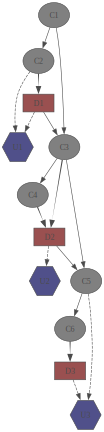

{1}
{2}
{5}
{2, 5}


In [3]:
# TESTS TESTS
# needs one more
# TESTS

figure2 = gum.InfluenceDiagram()
figure2.loadBIFXML('figure_2.bifxml')
gnb.showInfluenceDiagram(figure2)
decisionNodes = list(getDecisionNodes(figure2))
for d in decisionNodes:
    print(getRelO(figure2, {d}))
print(getRelO(figure2, {7, 8})) # conforme a l'exemple donné par l'article 

In [10]:
def frontdoorBetweenSets(bn: gum.BayesNet, causeSet: set[int], effectSet: set[int], notFD: set[int]=set()) -> set[int]:
    ''' 
    Description:
    Get all frontdoor sets between two sets of nodes

    Arguments:
    bn : gum.BayesNet
    causeSet : set[int]
    effectSet : set[int]
    notFD : set[int]

    Returns FD(causeSet, effectSet) excluding nodes in notFD
    '''
    if notFD is None:
        notFD = set()
    
    all_frontdoors = set()
    
    for cause in causeSet:  #loop through causeSet x effectSet
        for effect in effectSet:
            frontdoors = csl.frontdoor_generator(bn, cause, effect, notFD)
            if frontdoors:   # just the non empty bds
                for b in frontdoors:
                    all_frontdoors.add(*b)
                
    return all_frontdoors

def getRelH(id: gum.InfluenceDiagram, decisionSet: set[int]) -> set[int]:
    bayesNet = IDToBN(id)
    u_star = bayesNet.add(gum.LabelizedVariable('U*'))
    for u in getRelU(id, decisionSet):
        bayesNet.addArc(u, u_star)
    return bayesNet

In [12]:
relh = getRelH(figure2, {8})
relh


(pyagrum.BayesNet@0000020FD2704C60) BN{nodes: 13, arcs: 17, domainSize: 8192, dim: 35, mem: 560o}

In [18]:
frontdoorBetweenSets(relh, {5, 8}, {12})

{8}

In [7]:
topo = figure2.topologicalOrder()
topo = list(filter(lambda x : x in relh, topo))
topo

[]

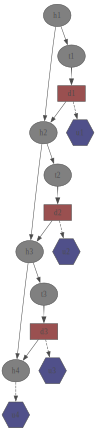

In [8]:
pigs = gum.InfluenceDiagram()
pigs.loadBIFXML('pigs_limid.bifxml')
gnb.showInfluenceDiagram(pigs)

In [ ]:
def decompose(id: gum.InfluenceDiagram) -> None:    # will return ClusterNode once two files are linked
    ''' 
    algo 1:
    evaluer REL_H de chaque decision seule, isoler celles qui forment un sous-modele stable
    combiner le reste jusqu'a avoir tout stable (hypothese qu'on peut arriver a une decomposition stable no matter what)
    algo 2:
    passer par ordre de decision, developper REL_H, recursivement developper les decision qui overlap avec
    '''
    pass